In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create data frame
df = pd.read_csv ('AirPassengers.csv')

In [3]:
# convert column Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# convert format
df['Date'] = df['Date'].dt.strftime('%Y-%m')
df.head()

,Date,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
# reset the index to Date
df.index = df['Date']
del df['Date']
df.head()

,#Passengers
Date,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


Text(0, 0.5, '#Passengers')

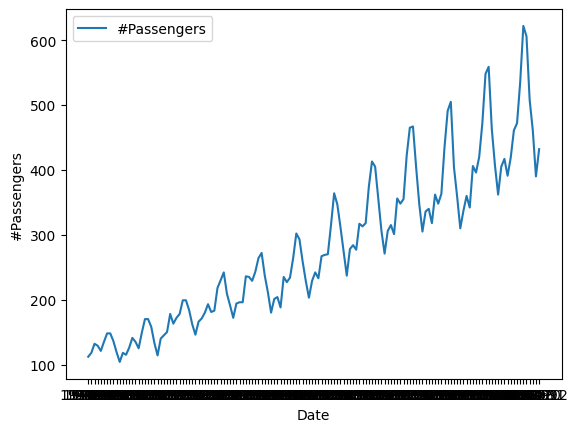

In [8]:
# generate a plot
sns.lineplot(df)
plt.ylabel ('#Passengers')

##### Stationarity
A stationary time series will not have trends or seasonal patterns. We will use the Dickey Fuller test to check for stationarity in our data. 

In [9]:
# obtain the seven-month rolling mean
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

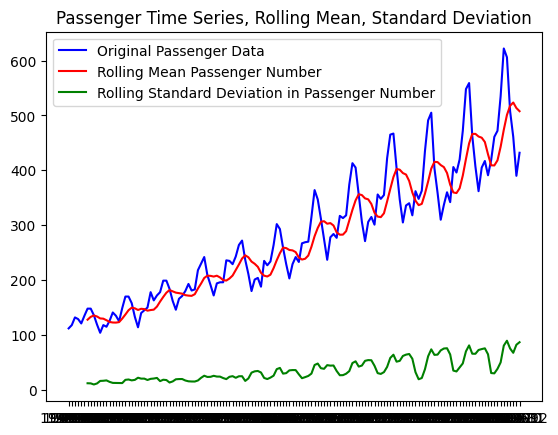

In [10]:
# make a plot
plt.plot (df, color = 'b', label = 'Original Passenger Data')
plt.plot (rolling_mean, color = 'r', label = 'Rolling Mean Passenger Number' )
plt.plot (rolling_std, color = 'g', label = 'Rolling Standard Deviation in Passenger Number')
plt.title ('Passenger Time Series, Rolling Mean, Standard Deviation')
plt.legend (loc = 'best')
plt.show()

In [11]:
# import the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

In [12]:
# AIC is the autolag parameter
adft = adfuller (df, autolag = 'AIC')

In [13]:
# store results in a data frame
output_df = pd.DataFrame({'Values': [adft[0], adft[1], adft[2], adft[3],
                                    adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                         'Metric': ['Test Statistics', 'p-value', 'No. of lags used',
                                   'Number of observations used', 'critical value (1%)',
                                   'critical value (5%)', 'critical value (10%)']
                         
                         })
print (output_df)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


##### Autocorrelation
This is a measure of how correlated a time series data is at a given point in time with past values. 

In [14]:
autocorr_lag1 = df['#Passengers'].autocorr (lag = 1)
print ('One Month Lag: ', autocorr_lag1)

One Month Lag:  0.9601946480498522


In [15]:
autocorr_lag3 = df['#Passengers'].autocorr (lag = 3)
print ('Three Month Lag: ', autocorr_lag3)

Three Month Lag:  0.837394765081794


In [16]:
autocorr_lag6 = df['#Passengers'].autocorr (lag = 6)
print ('Six Month Lag: ', autocorr_lag6)

Six Month Lag:  0.7839187959206183


In [17]:
autocorr_lag9 = df['#Passengers'].autocorr (lag = 9)
print ('Nine Month Lag: ', autocorr_lag3)

Nine Month Lag:  0.837394765081794


##### Decomposition

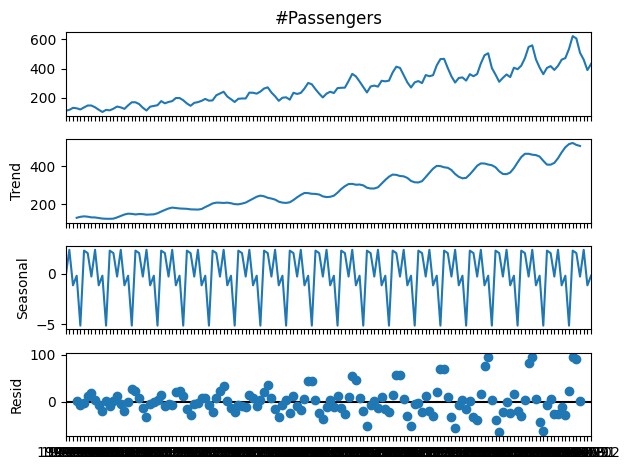

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose (df['#Passengers'], model = 'additive', period = 7)
sd.plot()
plt.show()

##### Forecasting
Time series forecasting allows us to predict future values in a time series given current and past data. We will use the ARIMA method to forecast the number of passengers in terms of a linear combination of past values. 

In [26]:
df.head()

,#Passengers,Month
Date,,
1949-01,112,1949-01-01
1949-02,118,1949-02-01
1949-03,132,1949-03-01
1949-04,129,1949-04-01
1949-05,121,1949-05-01


In [19]:
# split data into training and testing set
df['Month'] = df.index
df['Month'] = pd.to_datetime(df['Month'])
train = df[df['Month'] < pd.to_datetime ('1960-08', format = '%Y-%m')]
test = df[df['Month'] >= pd.to_datetime ('1960-08', format = '%Y-%m')]
del train['Month']
del test['Month']

In [20]:
train.head()

,#Passengers
Date,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [21]:
test.head()

,#Passengers
Date,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


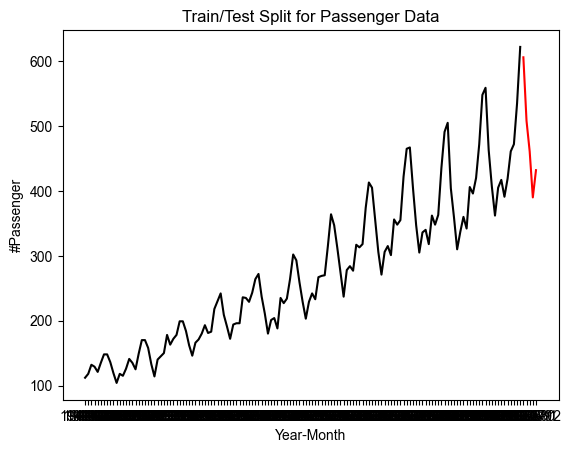

In [22]:
# visualize the two sets
plt.plot (train, color = 'black')
plt.plot (test, color = 'red')
plt.title ('Train/Test Split for Passenger Data')
plt.ylabel ('#Passenger')
plt.xlabel ('Year-Month')
sns.set()
plt.show()

In [23]:
# train our model and generate predictions
from pmdarima.arima import auto_arima

model = auto_arima (train, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit (train)

forecast = model.predict (n_periods = len(test))
forecast = pd.DataFrame (forecast, index = test.index, columns = ['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

In [24]:
# calculate the root mean squared error (RMSE)
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt (mean_squared_error (test, forecast))
print ('RMSE: ', rms)

RMSE:  61.366025336002586


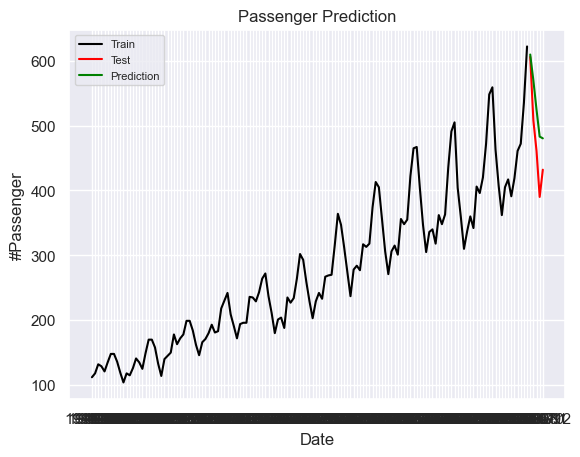

In [25]:
# visualize the two sets
plt.plot (train, label = 'Train', color = 'black')
plt.plot (test, label = 'Test', color = 'red')
plt.plot (forecast, label = 'Prediction', color = 'green')
plt.title ('Passenger Prediction')
plt.ylabel ('#Passenger')
plt.xlabel ('Date')
plt.legend (loc = 'upper left', fontsize = 8)
plt.show()